SnowCV method to quantify snow height from phenocam staff gauge imagery.
For NEON Battelle
Donal O'Leary
April 12 2021

Borrowing liberally from <a href="https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/" target="_blank">this awesome tutorial by Adrian Rosebrock</a>.

In [1]:
import cv2
import imutils
from imutils import contours
import argparse
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Next, we read in the number template image - this is what we will compare the phenocam imagery to, so you should make sure that your template digits look like the digits on the staff gauge!

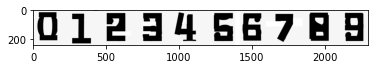

In [2]:
template = cv2.imread('/Users/olearyd/Git/SnowCV/data/number_template.png')
plt.imshow(template)

Next, we will perform some imager processing steps to convert to grayscale, reduce the size of this template image, and perform a Canny transform to extract the borders of the digits.

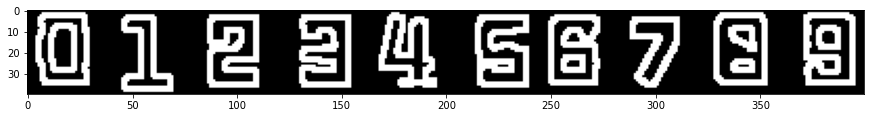

In [3]:
plt.rcParams['figure.figsize'] = [15, 15] # set plot size

kernel = np.ones((3,3),np.uint8)

template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.threshold(template, 10, 255, cv2.THRESH_BINARY)[1]
template = cv2.resize(template, (400,40))
template_Canny = cv2.Canny(template , 10, 255)
template_Canny = cv2.dilate(template_Canny, kernel,iterations = 1)

plt.imshow(template_Canny, cmap='gray')

Now that we have the outlines for each digit, we will use the `cv2.findcontours()` function to truly extract the exact contours, which will be used below to get the bounding box for each digit.

In [4]:
templateCnts = cv2.findContours(template_Canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
templateCnts = imutils.grab_contours(templateCnts)
templateCnts = contours.sort_contours(templateCnts, method="left-to-right")[0]

print('Length of templateCnts = '+str(len(templateCnts)))


Length of templateCnts = 10


Great! We now have a list of contours of length 10, which corresponds to our 10 digits in the template image.
Now let's take a look at the `templateCnts` object to see what that contains:

In [5]:
templateCnts

(array([[[ 7,  1]],
 
        [[ 5,  3]],
 
        [[ 5,  7]],
 
        [[ 6,  8]],
 
        [[ 5,  9]],
 
        [[ 5, 11]],
 
        [[ 4, 12]],
 
        [[ 4, 24]],
 
        [[ 5, 25]],
 
        [[ 5, 26]],
 
        [[ 6, 27]],
 
        [[ 6, 33]],
 
        [[ 7, 34]],
 
        [[ 7, 35]],
 
        [[29, 35]],
 
        [[29, 28]],
 
        [[28, 27]],
 
        [[29, 26]],
 
        [[29,  8]],
 
        [[28,  7]],
 
        [[28,  2]],
 
        [[27,  1]]], dtype=int32),
 array([[[47,  2]],
 
        [[45,  4]],
 
        [[45,  9]],
 
        [[46, 10]],
 
        [[52, 10]],
 
        [[53, 11]],
 
        [[53, 29]],
 
        [[52, 30]],
 
        [[47, 30]],
 
        [[45, 32]],
 
        [[45, 37]],
 
        [[46, 38]],
 
        [[69, 38]],
 
        [[69, 31]],
 
        [[68, 30]],
 
        [[62, 30]],
 
        [[61, 29]],
 
        [[61,  3]],
 
        [[60,  2]]], dtype=int32),
 array([[[ 87,   2]],
 
        [[ 87,   3]],
 
        [[ 86,   4]],
 


Next, we will make a new object `digits` which is a dictionary of images that are the individual digits in the template.

In [6]:
digits = {}

for (i, c) in enumerate(templateCnts):
	# compute the bounding box for the digit, extract it, and resize
	# it to a fixed size
	(x, y, w, h) = cv2.boundingRect(c)
	roi = template[y:y + h, x:x + w]
	roi = cv2.resize(roi, (57, 88))
	# update the digits dictionary, mapping the digit name to the ROI
	digits[i] = roi

Let's plot a 'digit' just to make sure that it has behaved as we expect:

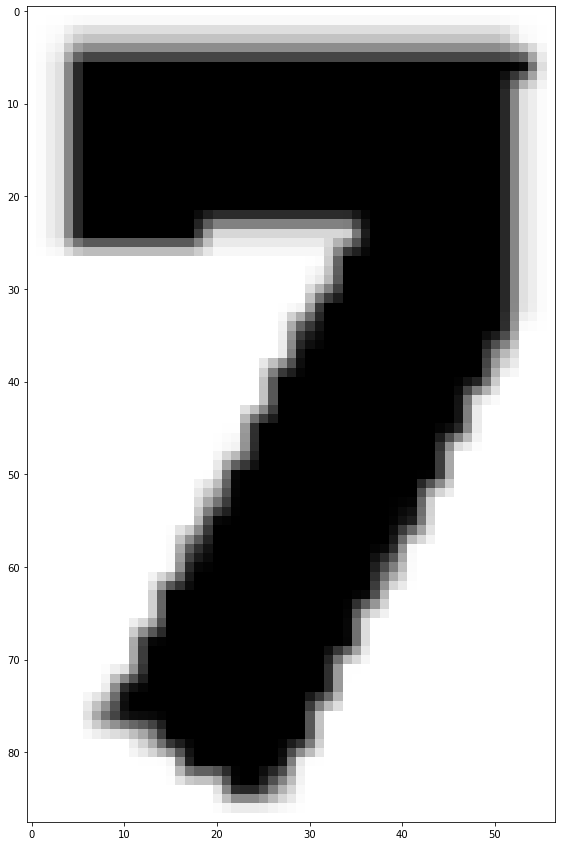

In [7]:
plt.imshow(digits[7], cmap='gray')

Awesome! We now have a dictionary of digits that we can use to compare against the phenocam-observed digits. This will be very useful later.

## Working with an Example Phenocam Image
For this next section, we will work with a single phenocam image to see if we can identify the digits that are on the staff gauge.

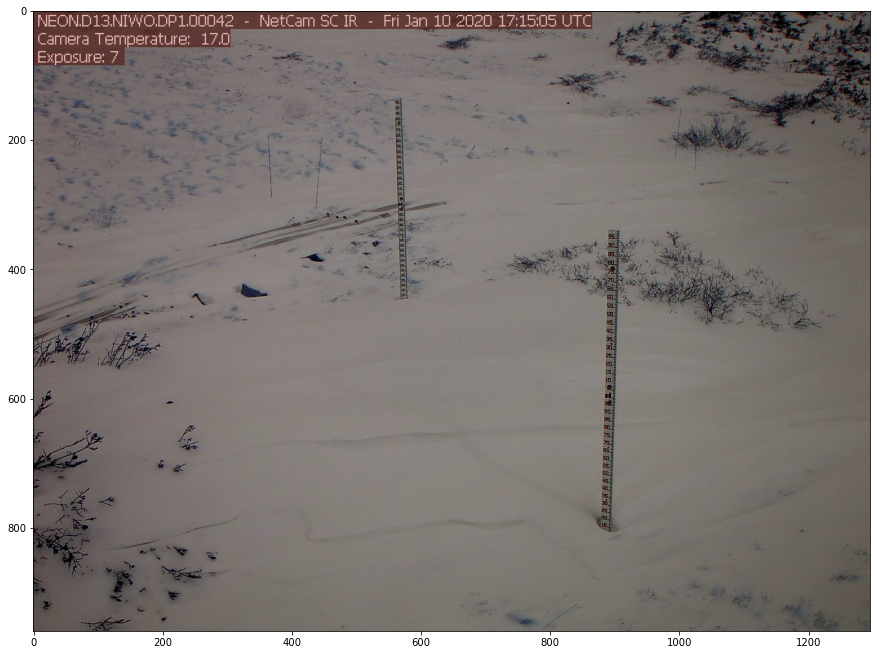

In [8]:
ref = cv2.imread('/Users/olearyd/Git/SnowCV/data/NEON.D13.NIWO.DP1.00042_2020_01_10_101505.jpg')
plt.rcParams['figure.figsize'] = [15, 15] # set plot size
plt.imshow(ref)

However, there is a problem here! The blue and red channels are reversed because `cv2.imread()` uses BGR as the default, whereas .jpg files are written in RGB order. So we can rearrange the channels and plot again.

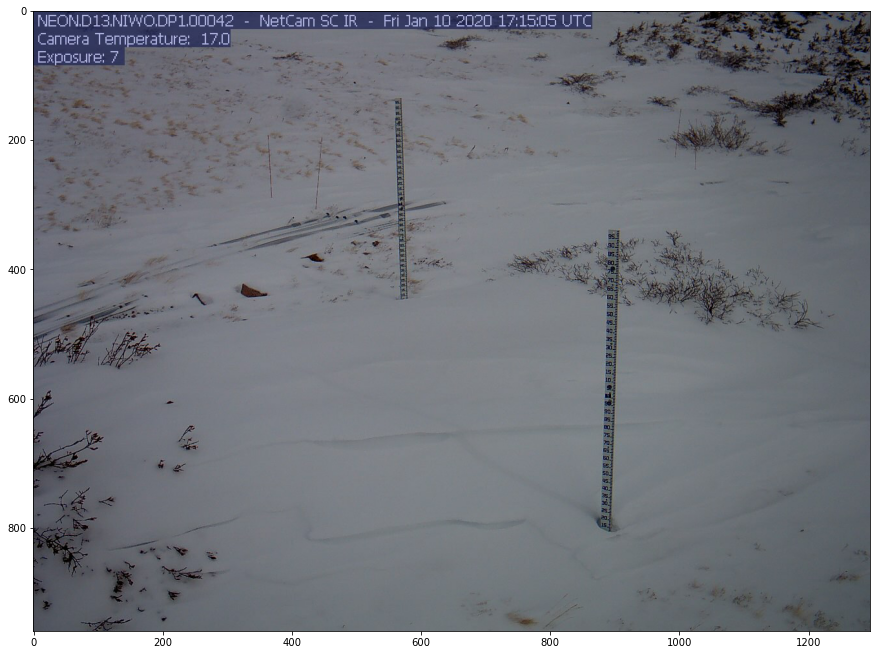

In [9]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(ref)

In any case, it is best practice to convert the three-color-channel image to a grayscale image for further processing. So we will convert this RGB image to Gray using the `cv2.cvtColor()` function with the `cv2.COLOR_RGB2GRAY` argument.

In [10]:

ref = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
ref = cv2.threshold(ref, 30, 255, cv2.THRESH_BINARY)[1]
ref

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

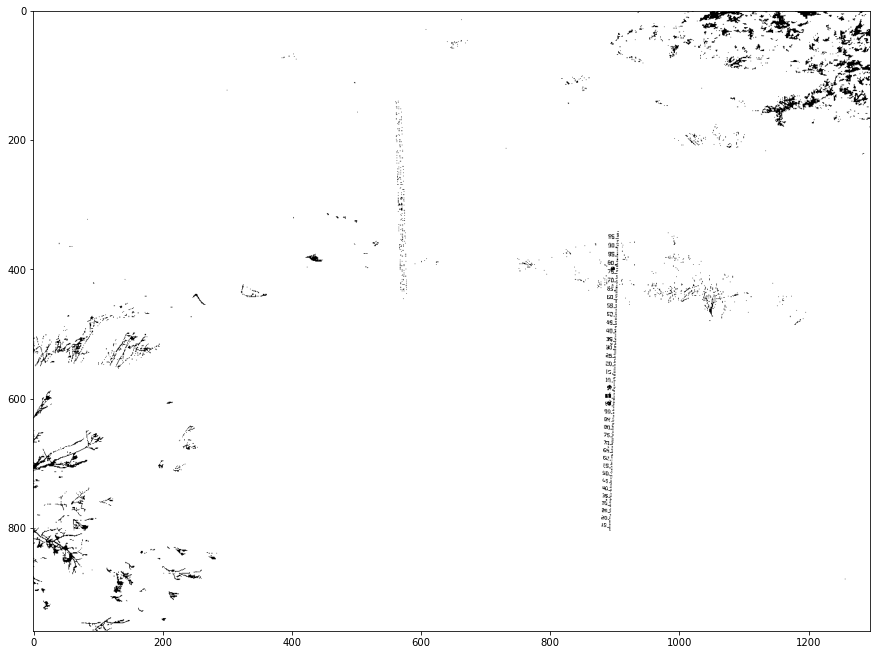

In [11]:
plt.imshow(ref, cmap='gray')

In [12]:
ROI = ref[600:850,870:920]

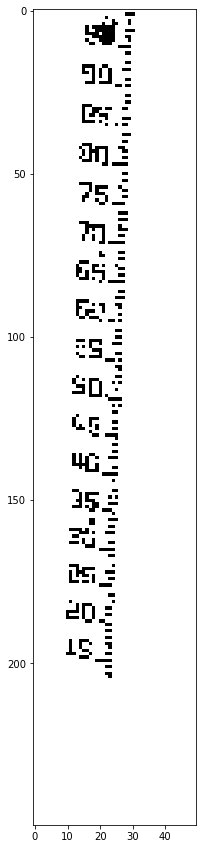

In [13]:
plt.rcParams['figure.figsize'] = [5, 15]
plt.imshow(ROI,cmap='gray')

In [14]:
# ## Plot image in external window
# cv2.imshow('image',ref)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

In [15]:
fifteen = ROI[192:200,8:19]
num_pair=fifteen

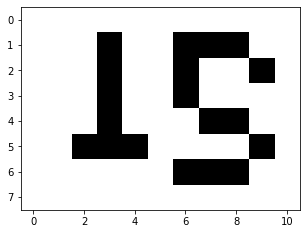

In [16]:
plt.imshow(fifteen,cmap='gray')

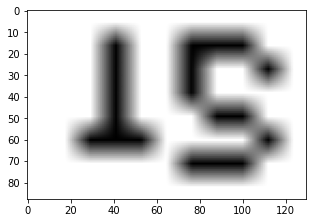

In [17]:
fifteen_big = cv2.resize(fifteen, (130,88))
plt.imshow(fifteen_big, cmap='gray')

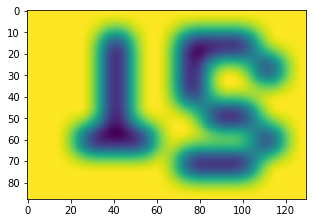

In [18]:
#kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
fifteen_big = cv2.blur(fifteen_big, (11,11))
plt.imshow(fifteen_big)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

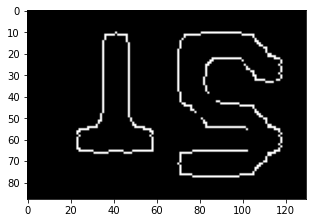

In [19]:
fifteen_big_Canny = cv2.Canny(fifteen_big, 10, 150)
plt.imshow(fifteen_big_Canny, cmap='gray')
fifteen_big_Canny

In [20]:
kernel = np.ones((5,5),np.uint8)

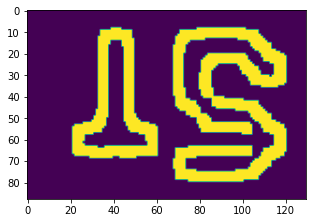

In [21]:
f_d = cv2.dilate(fifteen_big_Canny, kernel,iterations = 1)
plt.imshow(f_d)

In [22]:
## Get the contours of the individual numbers to then clip out each digit

num_pairCnts = cv2.findContours(f_d.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
num_pairCnts = imutils.grab_contours(num_pairCnts)
num_pairCnts = contours.sort_contours(num_pairCnts, method="left-to-right")[0]



In [23]:
len(num_pairCnts)

2

In [24]:
numbers = {}

for (i, c) in enumerate(num_pairCnts):
	# compute the bounding box for the digit, extract it, and resize
	# it to a fixed size
	(x, y, w, h) = cv2.boundingRect(c)
	roi = fifteen_big[y:y + h, x:x + w]
	roi = cv2.resize(roi, (57, 88))
	# update the digits dictionary, mapping the digit name to the ROI
	numbers[i] = roi

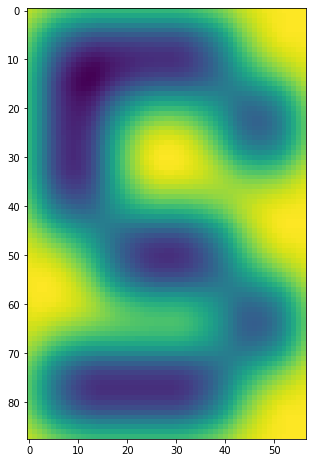

In [25]:
plt.imshow(numbers[1])

In [26]:


for i in range(len(numbers)):
#    print(i)
    scores=[]
    for j in range(len(digits)):
#        print(j)
        result = cv2.matchTemplate(numbers[i], digits[j], cv2.TM_CCOEFF)
        (_, score, _, _) = cv2.minMaxLoc(result)
        scores.append(score)
    print(str(np.argmax(scores)))
        
#str(np.argmax(scores))

1
9


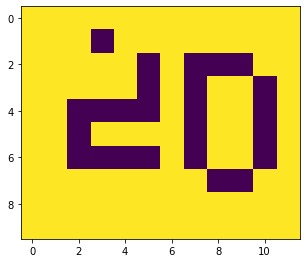

In [27]:
twenty = ROI[180:190,8:20]
plt.imshow(twenty)

In [44]:
def read_num_pair(img):
    # img is scaled black and white image of number pair (e.g., "20")
    i = cv2.resize(img, (130,88))
    i = cv2.blur(i, (11,11))
    i = cv2.Canny(i, 10, 150)

    kernel = np.ones((5,5),np.uint8)
    i = cv2.dilate(i, kernel,iterations = 1)
    
    #plt.imshow(i)
    
    num_pairCnts = cv2.findContours(i.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_pairCnts = imutils.grab_contours(num_pairCnts)
    num_pairCnts = contours.sort_contours(num_pairCnts, method="left-to-right")[0]
    
    numbers = {}
    for (ctr, c) in enumerate(num_pairCnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        (x, y, w, h) = cv2.boundingRect(c)
        roi = fifteen_big[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        # print(roi.shape)
        # update the digits dictionary, mapping the digit name to the ROI
        numbers[ctr] = roi
        
    #print(len(numbers))
    num_pair_guess = []
    for ctr2 in range(len(numbers)):
        #print(ctr2)
        scores=[]
        for j in range(len(digits)):
            #print('Begin j')
            #print(numbers[ctr2].shape)
            #print(digits[j].shape)
            result = cv2.matchTemplate(numbers[ctr2], digits[j], cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            #print(score)
            scores.append(score)
            #print(scores)
        #digit=np.argmax(scores)
        #print(digit)
        print('Scores')
        print(scores)
        num_pair_guess.append(np.argmax(scores))
    
    #print(scores)
    
    out = num_pair_guess[0]*10+num_pair_guess[1]
    
    return out
    
    #print(str(np.argmax(scores)))

(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
Scores
[-5637318.0, 30715046.0, 3590788.75, 4952536.5, 7250977.5, 8550905.0, 4280550.5, 14341259.0, 3917443.0, 1666368.0]
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
Scores
[11662232.0, 11625822.0, 12114019.0, 14915518.0, 6409514.5, 17684810.0, 17507426.0, 12741205.0, 14789583.0, 18500738.0]


19

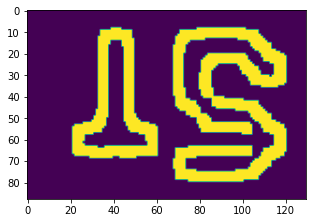

In [45]:
#digits
read_num_pair(fifteen)

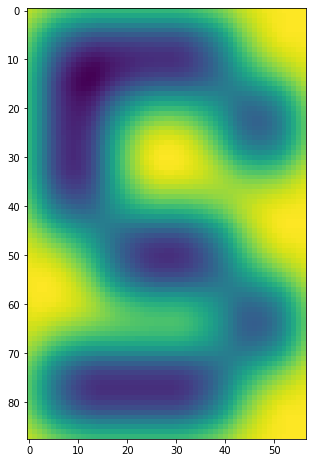

In [47]:
plt.imshow(numbers[1])

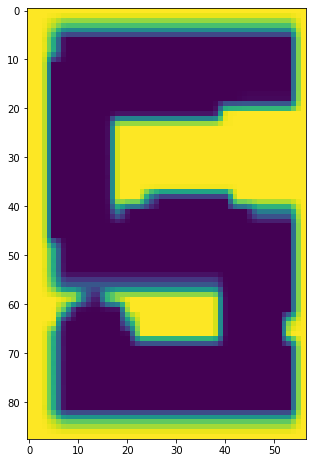

In [50]:
plt.imshow(digits[5])

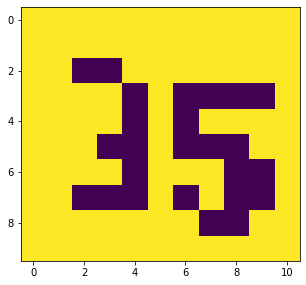

In [30]:
thirtyfive = ROI[145:155,10:21]
plt.imshow(thirtyfive)

Scores
[-7340590.5, 22210342.0, 377493.59375, 2385437.25, 11434718.0, 7629497.0, 1340132.5, 15455643.0, 2319386.5, -1704029.625]
Scores
[-138071.375, 6533875.0, 3609497.5, 3724506.0, 901675.9375, 9072734.0, 5653471.0, 7313578.5, 3692200.25, 3357028.5]


15

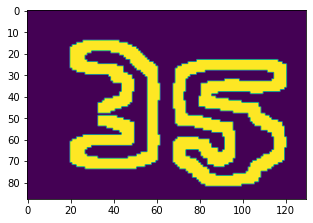

In [31]:
read_num_pair(thirtyfive)

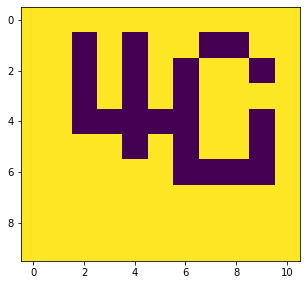

In [32]:
forty = ROI[135:145,10:21]
plt.imshow(forty)

Scores
[11485289.0, 4988871.5, 7512501.0, 7567635.0, 7635071.0, 9471388.0, 12743461.0, 2863419.5, 9192865.0, 12197342.0]


IndexError: list index out of range

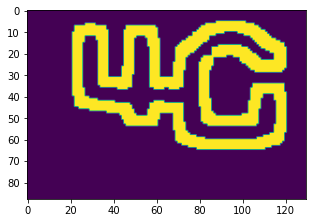

In [33]:
read_num_pair(forty)

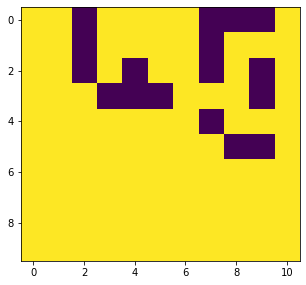

In [34]:
fortyfive = ROI[125:135,10:21]
plt.imshow(fortyfive)

Scores
[-3574180.0, 7412462.0, -719363.375, -2683273.0, -2943062.25, 1280612.5, -3385078.5, 10444.02734375, 4778979.5, -4383842.0]
Scores
[-4073019.0, 6808336.5, -380918.53125, -5716888.5, 3676833.0, 3182423.25, 2745315.75, -2191979.0, 2090113.625, -1479948.625]
Scores
[-5812478.5, 3772733.25, -2578527.25, -7193043.5, 10698262.0, 2753880.5, 3454697.0, -10858550.0, 3393372.5, -2200702.75]
Scores
[-3259012.5, 2003740.0, 820875.0625, -1738395.875, 9274400.0, 2796675.25, 1584444.375, 4279832.0, 2904065.25, 1296387.875]


11

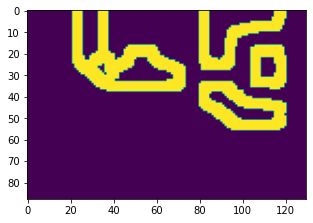

In [35]:
read_num_pair(fortyfive)

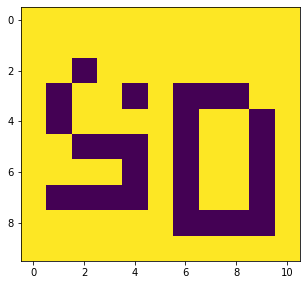

In [36]:
fifty = ROI[110:120,11:22]
plt.imshow(fifty)

Scores
[-4326830.5, 14542225.0, -42384.83984375, 7150137.0, 14047655.0, 5973289.5, 1161196.125, 18780902.0, 128624.625, 1500695.875]
Scores
[-2954014.0, -4131124.5, -3540693.25, -9325878.0, -3245662.75, -2792219.5, -383550.625, -8376177.5, -4208501.5, -3745390.25]
Scores
[-597152.5625, 5755270.5, 3241560.0, 2738919.0, 1638971.75, 8175931.0, 4516272.5, 7874006.5, 2953858.25, 2134779.0]


76

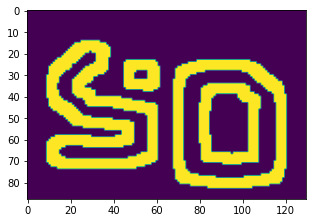

In [37]:
read_num_pair(fifty)

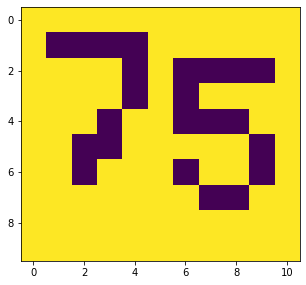

In [38]:
seventyfive = ROI[52:62,13:24]
plt.imshow(seventyfive)

(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
Scores
[-5327117.0, 23211926.0, 1039352.4375, 5176844.5, 10401338.0, 3541221.25, 3105308.0, 12815190.0, 162538.3125, 3375994.0]
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
(88, 57)
Scores
[5726276.5, 8126239.5, 5874755.0, 8033120.5, 3659258.5, 11888686.0, 11352994.0, 6764269.5, 9390248.0, 12803307.0]


19

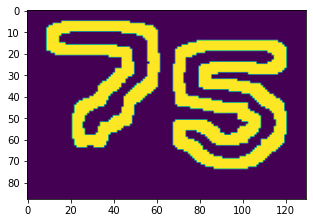

In [51]:
read_num_pair(seventyfive)

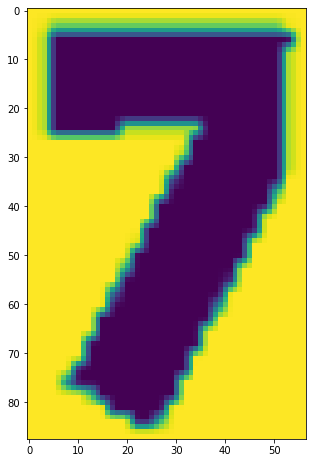

In [40]:
plt.imshow(digits[7])

In [41]:
digits[7].shape

(88, 57)